In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from os.path import exists
from tqdm import tqdm

from Levenshtein import distance

%matplotlib inline

In [3]:
def tcr_dist(tcr1, tcr2):
    d0 = distance(tcr1[0], tcr2[0])
    d1 = 1 - int(tcr1[1] == tcr2[1])
    d2 = 1 - int(tcr1[2] == tcr2[2])
    return d0 + d1 + d2

In [4]:
# settings
pep = "NLVPMVATV"

In [5]:
# load and prepare peptide-specific seqs for SONIA
vdgdb_df = pd.read_csv('./' + pep + '/VDJdb_' + pep + '_WithAligned20.csv')
vdgdb_df = vdgdb_df.drop_duplicates().reset_index(drop=True)
t_seqs = vdgdb_df['CDR3_beta'].to_list()
t_v = vdgdb_df['TRBV_gene'].to_list()
t_j = vdgdb_df['TRBJ_gene'].to_list()
sonia_input_vdgdb = [list(a) for a in zip(t_seqs, t_v, t_j)]

In [6]:
# load and prepare second set of Emerson seqs for SONIA (to be used as negative)
filename_cdr3raw = './train_data_1.txt' 
inds_non_overlap = np.loadtxt('./1_inds_nonoverlap_0.txt').astype(np.int16)
t_seq0 = []
with open(filename_cdr3raw) as f:
    for line in f:
        linesplit = line.strip().split('\n')
        t_seq0.append(linesplit[0])

t_seq = [x.split('\t') for x in np.array(t_seq0)[inds_non_overlap]]

# EXAMPLE with repl = 0

In [78]:
repl = 0
## prepare positives (train, test) ##
path_o ='./' + pep + '/indices/index_permutation_repl' + str(repl) + '.txt'
full_intR = (np.loadtxt(path_o)).astype(np.int16)
data = [sonia_input_vdgdb[t] for t in full_intR]
train_data = data[:int(80*len(data)/100)]
test_data = data[int(80*len(data)/100):]

## prepare negatives (test) ##
path_o ='./' + pep + '/indices/index_permutationN_repl' + str(repl) + '.txt'
full_intR = (np.loadtxt(path_o)).astype(np.int16)
test_dataN0 = [t_seq[t] for t in full_intR]
test_dataN = val_dataN0[:len(val_data)]
train_dataN = val_dataN0[len(val_data)+1:len(val_data)+len(train_data)+1]

In [88]:
L_val = int(0.2 * len(train_data))

rng = np.random.default_rng(1)
rng.shuffle(train_data)
rng.shuffle(train_dataN)

temp_train = train_data[:-L_val]
temp_val = train_data[-L_val:]
temp_trainN = train_dataN[:-L_val]
temp_valN = train_dataN[-L_val:]

In [100]:
AUCs = []
for k in tqdm(range(1, 51)):
    # compute AUROC
    res_pos = []
    for x in temp_val:
        ts = x
        ave_dists_plus = np.mean(sorted([tcr_dist(ts, x) for x in temp_train])[:k])
        ave_dists_minus = np.mean(sorted([tcr_dist(ts, x) for x in temp_trainN])[:k])
        res_pos.append(ave_dists_minus - ave_dists_plus)
    res_pos = np.array(res_pos)
    
    res_neg = []
    for x in temp_valN:
        ts = x
        ave_dists_plus = np.mean(sorted([tcr_dist(ts, x) for x in temp_train])[:k])
        ave_dists_minus = np.mean(sorted([tcr_dist(ts, x) for x in temp_trainN])[:k])
        res_neg.append(ave_dists_minus - ave_dists_plus)
    res_neg = np.array(res_neg)
    
    scores_positive = res_pos
    scores_negative = res_neg    
    labels = np.hstack((np.zeros((len(res_neg))), np.ones((len(res_pos))))) 
    scores = np.hstack((scores_negative, scores_positive))
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    AUCs.append(metrics.auc(fpr, tpr))   

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [03:23<00:00,  4.06s/it]


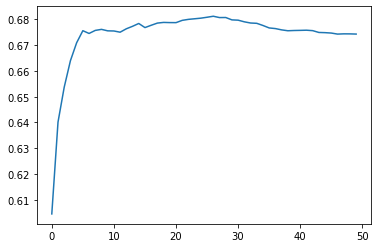

In [102]:
plt.plot(AUCs)

In [104]:
k = np.argmax(AUCs) + 1
k

27

In [105]:
# compute AUROC of test set with the best k 
res_pos = []
for x in test_data:
    ts = x
    ave_dists_plus = np.mean(sorted([tcr_dist(ts, x) for x in train_data])[:k])
    ave_dists_minus = np.mean(sorted([tcr_dist(ts, x) for x in train_dataN])[:k])
    res_pos.append(ave_dists_minus - ave_dists_plus)
res_pos = np.array(res_pos)

res_neg = []
for x in test_dataN:
    ts = x
    ave_dists_plus = np.mean(sorted([tcr_dist(ts, x) for x in train_data])[:k])
    ave_dists_minus = np.mean(sorted([tcr_dist(ts, x) for x in train_dataN])[:k])
    res_neg.append(ave_dists_minus - ave_dists_plus)
res_neg = np.array(res_neg)

scores_positive = res_pos
scores_negative = res_neg    
labels = np.hstack((np.zeros((len(res_neg))), np.ones((len(res_pos))))) 
scores = np.hstack((scores_negative, scores_positive))
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
metrics.auc(fpr, tpr)

0.7075697379543533

In [ ]:
# now we run the full thing (starting from k = 5 and ending in 40 this time)

In [115]:
min_k = 5
max_k = 50
test_AUROCs = []
best_ks = []
for i in range(50):
    print("Working on repl =", i, "...")
    repl = i
    ## prepare positives (train, test) ##
    path_o ='./' + pep + '/indices/index_permutation_repl' + str(repl) + '.txt'
    full_intR = (np.loadtxt(path_o)).astype(np.int16)
    data = [sonia_input_vdgdb[t] for t in full_intR]
    train_data = data[:int(80*len(data)/100)]
    test_data = data[int(80*len(data)/100):]
    
    ## prepare negatives (test) ##
    path_o ='./' + pep + '/indices/index_permutationN_repl' + str(repl) + '.txt'
    full_intR = (np.loadtxt(path_o)).astype(np.int16)
    test_dataN0 = [t_seq[t] for t in full_intR]
    test_dataN = val_dataN0[:len(val_data)]
    train_dataN = val_dataN0[len(val_data)+1:len(val_data)+len(train_data)+1]
    
    # split in train/validation
    L_val = int(0.2 * len(train_data))
    rng = np.random.default_rng(1)
    rng.shuffle(train_data)
    rng.shuffle(train_dataN)    
    temp_train = train_data[:-L_val]
    temp_val = train_data[-L_val:]
    temp_trainN = train_dataN[:-L_val]
    temp_valN = train_dataN[-L_val:]
    
    # gridsearch for optimal k
    val_AUCs = []
    for k in tqdm(range(min_k, max_k+1)):
        # compute AUROC
        res_pos = []
        for x in temp_val:
            ts = x
            ave_dists_plus = np.mean(sorted([tcr_dist(ts, x) for x in temp_train])[:k])
            ave_dists_minus = np.mean(sorted([tcr_dist(ts, x) for x in temp_trainN])[:k])
            res_pos.append(ave_dists_minus - ave_dists_plus)
        res_pos = np.array(res_pos)
        
        res_neg = []
        for x in temp_valN:
            ts = x
            ave_dists_plus = np.mean(sorted([tcr_dist(ts, x) for x in temp_train])[:k])
            ave_dists_minus = np.mean(sorted([tcr_dist(ts, x) for x in temp_trainN])[:k])
            res_neg.append(ave_dists_minus - ave_dists_plus)
        res_neg = np.array(res_neg)
        
        scores_positive = res_pos
        scores_negative = res_neg    
        labels = np.hstack((np.zeros((len(res_neg))), np.ones((len(res_pos))))) 
        scores = np.hstack((scores_negative, scores_positive))
        fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
        val_AUCs.append(metrics.auc(fpr, tpr))
    k = np.argmax(val_AUCs) + min_k
    best_ks.append(k)
    
    # compute AUROC of test set with the best k 
    res_pos = []
    for x in test_data:
        ts = x
        ave_dists_plus = np.mean(sorted([tcr_dist(ts, x) for x in train_data])[:k])
        ave_dists_minus = np.mean(sorted([tcr_dist(ts, x) for x in train_dataN])[:k])
        res_pos.append(ave_dists_minus - ave_dists_plus)
    res_pos = np.array(res_pos)
    
    res_neg = []
    for x in test_dataN:
        ts = x
        ave_dists_plus = np.mean(sorted([tcr_dist(ts, x) for x in train_data])[:k])
        ave_dists_minus = np.mean(sorted([tcr_dist(ts, x) for x in train_dataN])[:k])
        res_neg.append(ave_dists_minus - ave_dists_plus)
    res_neg = np.array(res_neg)
    
    scores_positive = res_pos
    scores_negative = res_neg    
    labels = np.hstack((np.zeros((len(res_neg))), np.ones((len(res_pos))))) 
    scores = np.hstack((scores_negative, scores_positive))
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    test_AUROCs.append(metrics.auc(fpr, tpr))

Working on repl = 0 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:16<00:00,  4.27s/it]


Working on repl = 1 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:14<00:00,  4.22s/it]


Working on repl = 2 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:09<00:00,  4.12s/it]


Working on repl = 3 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:13<00:00,  4.20s/it]


Working on repl = 4 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:15<00:00,  4.24s/it]


Working on repl = 5 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:10<00:00,  4.15s/it]


Working on repl = 6 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:20<00:00,  4.35s/it]


Working on repl = 7 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:10<00:00,  4.15s/it]


Working on repl = 8 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:11<00:00,  4.17s/it]


Working on repl = 9 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:12<00:00,  4.19s/it]


Working on repl = 10 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:09<00:00,  4.11s/it]


Working on repl = 11 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:11<00:00,  4.16s/it]


Working on repl = 12 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:10<00:00,  4.13s/it]


Working on repl = 13 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:09<00:00,  4.12s/it]


Working on repl = 14 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:09<00:00,  4.12s/it]


Working on repl = 15 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:10<00:00,  4.13s/it]


Working on repl = 16 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:13<00:00,  4.21s/it]


Working on repl = 17 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:12<00:00,  4.18s/it]


Working on repl = 18 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:17<00:00,  4.29s/it]


Working on repl = 19 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:12<00:00,  4.18s/it]


Working on repl = 20 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:10<00:00,  4.15s/it]


Working on repl = 21 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:11<00:00,  4.16s/it]


Working on repl = 22 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:11<00:00,  4.17s/it]


Working on repl = 23 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:13<00:00,  4.22s/it]


Working on repl = 24 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:20<00:00,  4.36s/it]


Working on repl = 25 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:16<00:00,  4.27s/it]


Working on repl = 26 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:05<00:00,  4.04s/it]


Working on repl = 27 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:05<00:00,  4.03s/it]


Working on repl = 28 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:04<00:00,  4.02s/it]


Working on repl = 29 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:03<00:00,  3.98s/it]


Working on repl = 30 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [06:13<00:00,  8.13s/it]


Working on repl = 31 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:03<00:00,  3.99s/it]


Working on repl = 32 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:03<00:00,  3.99s/it]


Working on repl = 33 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:05<00:00,  4.04s/it]


Working on repl = 34 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:16<00:00,  4.28s/it]


Working on repl = 35 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:16<00:00,  4.28s/it]


Working on repl = 36 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:03<00:00,  3.99s/it]


Working on repl = 37 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:16<00:00,  4.28s/it]


Working on repl = 38 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:03<00:00,  3.99s/it]


Working on repl = 39 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:51<00:00,  5.04s/it]


Working on repl = 40 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [04:18<00:00,  5.62s/it]


Working on repl = 41 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [04:23<00:00,  5.74s/it]


Working on repl = 42 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [04:05<00:00,  5.33s/it]


Working on repl = 43 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [04:07<00:00,  5.37s/it]


Working on repl = 44 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [04:13<00:00,  5.52s/it]


Working on repl = 45 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [04:02<00:00,  5.27s/it]


Working on repl = 46 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [03:57<00:00,  5.17s/it]


Working on repl = 47 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [04:16<00:00,  5.57s/it]


Working on repl = 48 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [04:13<00:00,  5.52s/it]


Working on repl = 49 ...


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [04:21<00:00,  5.68s/it]


In [121]:
np.savetxt('./' + pep + '/AUROCs_kNN_nestedCrossval.txt', test_AUROCs)

In [122]:
np.mean(test_AUROCs), np.std(test_AUROCs)

(0.700110071247434, 0.011535148058128464)

In [125]:
np.mean(best_ks)

26.4

In [123]:
best_ks

[19,
 43,
 35,
 26,
 49,
 22,
 17,
 23,
 30,
 34,
 26,
 19,
 26,
 34,
 33,
 14,
 34,
 7,
 23,
 33,
 10,
 34,
 23,
 26,
 21,
 18,
 19,
 19,
 29,
 29,
 26,
 30,
 12,
 18,
 33,
 21,
 19,
 35,
 31,
 29,
 32,
 29,
 35,
 26,
 49,
 21,
 15,
 25,
 34,
 25]

In [124]:
test_AUROCs

[0.7028438594372659,
 0.6939071368192247,
 0.7076832508151188,
 0.6905784325564546,
 0.678665016302379,
 0.7069405868856418,
 0.6796848206738317,
 0.6958881777563097,
 0.7191589180050719,
 0.7068699432435697,
 0.7161459968602827,
 0.6943774906412269,
 0.7104015215553677,
 0.7031312643400555,
 0.7116875981161694,
 0.6799595459485571,
 0.7017135611641107,
 0.6752541963530975,
 0.7003188020770439,
 0.7055144306243207,
 0.6908302137423017,
 0.7090816326530612,
 0.694952300446806,
 0.6953465765004226,
 0.6960035019925128,
 0.6919665499335829,
 0.6995399106388117,
 0.6968023185605603,
 0.6966338606448497,
 0.6964074387151309,
 0.6863023789397417,
 0.7196316869943242,
 0.7048454292959786,
 0.6904745803646902,
 0.6935762589059293,
 0.7128239343074507,
 0.6938467576379665,
 0.7060964859316508,
 0.7026204564666102,
 0.7096153846153845,
 0.6967860161816206,
 0.7064068349233182,
 0.7233594976452119,
 0.693523125226422,
 0.7006188866078975,
 0.7088757396449704,
 0.6703326892887334,
 0.7063881173771